# Image Captioning:  Final Project
### Zac Espinosa
#### Project Description: 
This project attempts to tackle the task of image captioning using deep learning. 



## Set Up Project

In [1]:
# Setup
import numpy as np
import h5py
# from pycocotools.coco import COCO
import json
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import sampler
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dset
import torchvision.models as models
import torch.multiprocessing as mp
import os
from collections import defaultdict
import random
import urllib.request, urllib.error, urllib.parse, os, tempfile
from scipy.misc import imread, imresize
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import sentence_bleu
from sklearn.decomposition import PCA
from nltk.translate.bleu_score import SmoothingFunction

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Utility Functions

In [51]:
## Utility Functions ##
# Magic Numbers
TRAIN_CAPTIONS = 0 
TRAIN_IMAGE_IDXS = 1
VAL_CAPTIONS = 2
VAL_IMAGE_IDXS = 3 
FEATURES = 0
EMBED_SIZE = 300
FEATURE_SIZE = 512
BATCH_SIZE = 1
USE_GLOVE = False

#### USED FROM STANFORD CS231n as utility function ####
def image_from_url(url):
    try:
        f = urllib.request.urlopen(url)
    # t_handle is the opened file handle
        t_handle, fname = tempfile.mkstemp()
    # close it explicitly
        os.close(t_handle)
        with open(fname, 'wb') as ff:
            ff.write(f.read())
        img = imread(fname)
        os.remove(fname)
        return img
    except urllib.error.URLError as e:
        print('URL Error: ', e.reason, url)
    except urllib.error.HTTPError as e:
        print('HTTP Error: ', e.code, url)

# Returns Keys from a H5PY file
def keys(f):
    return list(f.keys())

## Performs PCA on input ## 
def perform_pca(data, size):
    pca = PCA(n_components=size)
    data = np.transpose(data)
    pca.fit(data)
    pca_matrix = torch.from_numpy(np.transpose(pca.components_)).type(torch.FloatTensor)
    return pca_matrix

def preprocess_captions(captions):
    captions = np.array(captions)
    unsort_len = captions.astype(bool).sum(axis=1)
    r = np.argsort(unsort_len)[::-1] # The sorted (descending) list of columns
    captions = captions[r,:]
    lengths = np.sort(unsort_len)[::-1]
    return lengths, torch.from_numpy(captions).long()

def process_targets(targets): # Target is shape (1,17)
    targets = torch.cat((targets[:,1:], torch.zeros(1,BATCH_SIZE).long().to(device)), dim=1)
    return targets[0]

def get_embeddings(captions):
    captions = captions[0]
    idx_to_word = vocab['idx_to_word']
    embeddings = []
    for i in captions:
        embeddings.append(glove_dict[idx_to_word[i]])
    embeddings = torch.from_numpy(np.stack(embeddings, axis=0)).float().to(device)
    embeddings = embeddings.unsqueeze(0)
    return embeddings

## Glove Embeddings:
Glove word embeddings are used for experimentation

In [52]:
def glove2dict(src_filename):
    """GloVe Reader.
    Parameters
    ----------
    src_filename : str
        Full path to the GloVe file to be processed.
    Returns
    -------
    dict
        Mapping words to their GloVe vectors.
    """
    data = {}
    with open(src_filename,  encoding='utf8') as f:
        while True:
            try:
                line = next(f)
                line = line.strip().split()
                data[line[0]] = np.array(line[1: ], dtype=np.float)
            except StopIteration:
                break
            except UnicodeDecodeError:
                pass
    return data

# No Mapping for these
unknowns = ["<NULL>", "<START>", "<END>", "<UNK>"]
DIRECTORY = 'coco/annotations/'

# Get Glove Embeddings
def get_glove(dims):
    file = '.'.join(('glove.6B', ''.join((str(dims), 'd')), 'txt')) 
    glove_dict = glove2dict(os.path.join(DIRECTORY, 'glove.6B', file))
    for unknown in unknowns: glove_dict[unknown] = np.random.rand(dims)
    return glove_dict

glove_dict = get_glove(300)

## Set Device

In [53]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else: 
    device = torch.device("cpu")

## Get Data 
The following datafiles are taken from Stanford CS231n: Convolutional Neural Networks for Vision Recognition. The data is generated from the MSCOCO dataset and formmated by this Stanford course.

In [54]:
## Retrieve Vocbulary 
def get_vocab():
    vocab_path = ''.join((DIRECTORY, 'coco2014_vocab.json'))
    with open(vocab_path) as f:
        vocab = json.load(f)
        return vocab

def get_data(small=False, small_size=None, pca=False, pca_size=None):
    val_data = {}
    train_data = {}
    
    # Val Features
    if pca: feat_dir =  'val2014_vgg16_fc7_pca.h5'
    else: feat_dir = 'val2014_vgg16_fc7.h5'
        
    val_path = ''.join((DIRECTORY, feat_dir))
    val_feats = h5py.File(val_path, 'r')
    val_feat_keys = keys(val_feats)
    # Get Features
    val_data['features'] = torch.from_numpy(np.asarray(val_feats[val_feat_keys[FEATURES]]))
    
    # PCA on Val Features
    #if pca: val_data['features'] = perform_pca(val_data['features'], pca_size)    
    # Small Set
    if small: val_data['features'] = val_data['features'][:small_size]    
        
    # Train Features
    if pca: feat_dir =  'train2014_vgg16_fc7_pca.h5'
    else: feat_dir = 'train2014_vgg16_fc7.h5'
        
    train_path = ''.join((DIRECTORY, feat_dir))
    train_feats = h5py.File(train_path, 'r')
    train_feat_keys = keys(train_feats)
    # Get Features
    train_data['features'] = torch.from_numpy(np.asarray(train_feats[train_feat_keys[FEATURES]]))
    # PCA on Train Features
    #if pca: train_data['features'] = perform_pca(train_data['features'], pca_size) 
    # Small Set
    if small: train_data['features'] = train_data['features'][:small_size]

    
    # Captions 
    caption_path = ''.join((DIRECTORY, 'coco2014_captions.h5'))
    captions = h5py.File(caption_path, 'r')
    caption_keys = keys(captions)
    val_data['captions'] = torch.from_numpy(np.asarray(captions[caption_keys[VAL_CAPTIONS]], dtype=int))
    val_data['image_idxs'] = np.asarray(captions[caption_keys[VAL_IMAGE_IDXS]], dtype=int)
    train_data['captions'] = torch.from_numpy(np.asarray(captions[caption_keys[TRAIN_CAPTIONS]], dtype=int))
    train_data['image_idxs'] = np.asarray(captions[caption_keys[TRAIN_IMAGE_IDXS]], dtype=int)
    
    # URLS
    train_url_file = os.path.join(DIRECTORY, 'train2014_urls.txt')
    with open(train_url_file, 'r') as f:
        train_urls = np.asarray([line.strip() for line in f])
    train_data['urls'] = train_urls

    val_url_file = os.path.join(DIRECTORY, 'val2014_urls.txt')
    with open(val_url_file, 'r') as f:
        val_urls = np.asarray([line.strip() for line in f])
    val_data['urls'] = val_urls
    
    return train_data, val_data

## Dataloaders

In [55]:
class MSCOCO(Dataset):
    """
    A customized data loader for MSCOCO.
    """
    def __init__(self,
                 data, vocab):
        """ 
        Args:
            - root: root directory of the dataset
            - tranform: a custom tranform function
            - preload: if preload the dataset into memory
        """
        self.captions = data['captions']
        self.img_idxs = data[ 'image_idxs']
        self.urls = data['urls']
        self.features = data['features']
        self.len = self.features.shape[0]
        self.vocab = vocab
        
        # Create Map of Img to Captions
        img_to_idx = defaultdict(list)
        for i in range(len(data["image_idxs"])):
            img_to_idx[data["image_idxs"][i]].append(i)           
        self.img_map = img_to_idx
        
        
    def get_url(self, idx):
        return self.urls[idx]
    
    def get_len(self):
        return self.len
    
    def get_sample(self, idx):
        caption_idxs = self.img_map[idx]
        captions_words = []
        captions_idx = []
        idx_to_word = self.vocab['idx_to_word']
        for cap in caption_idxs: 
            captions_words.append([idx_to_word[idxs] for idxs in self.captions[cap]])
            captions_idx.append(self.captions[cap])
        return self.features[idx], captions_words, captions_idx
    
    def __getitem__(self, idx):
        ## Return image information (features, captions) ## 
        caption_idxs = self.img_map[idx]
        caption_idxs = random.choice(caption_idxs)
        cur_caption = self.captions[caption_idxs]
        return self.features[idx], cur_caption.long()
              
    def __len__(self):
        return self.len

### Create DataLoaders
Only run one of these two cells to save space

In [ ]:
# Normal Training Loaders
vocab = get_vocab()
train_data, val_data = get_data(False, None, True, EMBED_SIZE)

trainset = MSCOCO(train_data, vocab) 
trainset_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)

valset = MSCOCO(val_data, vocab)
valset_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)

In [56]:
# Small Training Loaders
vocab = get_vocab()
small_train_data, small_val_data = get_data(False, None, True, FEATURE_SIZE)

trainset = MSCOCO(small_train_data, vocab) 
trainset_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)

valset = MSCOCO(small_val_data, vocab)
valset_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=True, num_workers=5)

## Model Checkpointing

In [57]:
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {'state_dict': model.state_dict(),
             'optimizer' : optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('model saved to %s' % checkpoint_path)
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('model loaded from %s' % checkpoint_path)

## Create Model

In [58]:
## Create Simple LSTM Model ## 
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, dropout=0, num_layers=1, max_length=20, use_glove=True):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_length = max_length
        self.use_glove = use_glove

    def forward(self, captions, features, lengths):
        # Get Embeddings
        if self.use_glove:
            embeddings = get_embeddings(captions)
        else: embeddings = self.embed(captions)
        # Create Hiddens    
        h0 = features.unsqueeze(0)
        tensor = torch.tensor((), dtype=torch.int32)
        c0 = tensor.new_zeros(h0.size()).float().to(device)
        hiddens = (h0, c0)
        # Run through Model
        hiddens, _ = self.lstm(embeddings, hiddens)
        outputs = self.linear(hiddens.squeeze(0))
        return outputs

    def sample(self, h, states=None):
        sample_idx = []
        # Create Features (feature vector)
        h = h.unsqueeze(0)
        h = h.unsqueeze(1)
        # Create c 
        tensor = torch.tensor((), dtype=torch.int32)
        c = tensor.new_zeros(h.size()).float().to(device)
        # Create Hiddens
        hiddens = (h,c)
        # Create First Word Embedding (<Start>)
        word = torch.ones(1).long().to(device)
        if self.use_glove:
            word = get_embeddings(word.unsqueeze(1))
        else:
            word = self.embed(word)
            word = word.unsqueeze(1)
        
        for i in range(self.max_length):
            outputs, hiddens = self.lstm(word, hiddens)
            outputs = self.linear(outputs.squeeze(1)) 
            _, predicted = outputs.max(1)
            sample_idx.append(predicted)
            if self.use_glove:
                word = get_embeddings(predicted.unsqueeze(1))
            else: 
                word = self.embed(predicted) 
                word = word.unsqueeze(1)
        return sample_idx

## Graph Metrics

In [59]:
## Graph Result ##
def graph_loss(loss):
    ## Loss vs Epochs
    plt.subplot(2, 1, 1)
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(range(len(loss)), loss, '-o', label='loss')
    plt.legend(loc='lower center')
    
    plt.gcf().set_size_inches(12, 15)
    plt.show()

def graph_bleu_scores(scores):
    plt.subplot(2, 1, 1)
    plt.title('Bleu Score vs Iterations')
    plt.xlabel('Iteration*100')
    plt.ylabel('bleu_score')
    plt.semilogx(range(len(scores)), scores, '-o', label='bleu_score', color='red')
    plt.legend(loc='lower center')
    
    plt.gcf().set_size_inches(15, 10)
    plt.show()

## Train Model

In [60]:
## Train Function ##
criterion = nn.CrossEntropyLoss()

def train(decoder, data_loader, nlength, epochs, model_name, optimizer, batch_size=64, checkpoint=False):
    decoder.to(device)
    decoder.train()
    total_loss, bleu_scores = [], []
    j = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for i, (images, captions) in enumerate(data_loader):
            # Send to GPU or CPU
            images, captions = images.to(device), captions.to(device)
            # Update Model            
            output = decoder(captions, images, None)
            #_, predicted = output.max(1)
            # Get Target Captions
            target = process_targets(captions)
            #print(predicted, target)
            loss = criterion(output, target)
            decoder.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            
        # Save and Print Metrics
        epoch_loss /= (nlength/batch_size)
        print("Epoch Loss = {} for Epoch {}".format(epoch_loss, epoch))
        total_loss.append(epoch_loss)
        # Checkpoint Model
        if checkpoint and epoch % 10 == 0:
            save_checkpoint('%s_%i.pth' % (model_name, int(epoch/10)), decoder, optimizer)
            
    # Save Final Model
    if checkpoint: 
        save_checkpoint('%s_%i_final.pth' % (model_name, int(epochs/10)), decoder, optimizer)
        
    return total_loss

## Sample Model

In [76]:
## Sample Model ##
def decode_caption(ids):
    caption = []
    idx_to_word = vocab['idx_to_word']
    for i in ids: caption.append(idx_to_word[i])
    return caption

def clean_captions(caption):
    for i, word in enumerate(caption):
        if word == "<END>":
            return caption[1:i]
    return caption[1:]

## Visualize Image and Caption ##
def visualize_sample(url, target_cap, generated_cap):    
    plt.imshow(image_from_url(url))
    plt.axis('off')
    plt.title(target_cap)
    plt.show()
    print(generated_cap)

def sample_model(decoder,idx, dataset, verbose=True):
    url = dataset.get_url(idx)
    print(url)
    feats, target_captions_words, target_captions_idx = dataset.get_sample(idx)
    feats = feats.to(device)
    decoder.eval()
#     output = decoder.forward(target_captions_idx[1].unsqueeze(0).to(device), feats.unsqueeze(0), None)
#     _, predicted = output.max(1)
    predicted = decoder.sample(feats)
    gen_caption = decode_caption(predicted)
    if verbose: visualize_sample(url, target_captions_words[0], gen_caption)
    return gen_caption, target_captions_words 

## Blue Score

In [62]:
def compute_bleu(decoder, num_samples, dataset, weights): 
    bleu_score = 0
    for i in range(num_samples):
        gen_caption, target_captions = sample_model(decoder, i, dataset, False)
        gen_caption = clean_captions(gen_caption)
        for i, caption in enumerate(target_captions): 
            target_captions[i] = clean_captions(caption)
        bleu_score += sentence_bleu(target_captions, gen_caption, weights, smoothing_function=SmoothingFunction().method3)
    bleu_score /= num_samples
    return bleu_score

## Baseline Model

In [107]:
# Train Model
dropout = .5
USE_GLOVE = True
decoder = DecoderRNN(EMBED_SIZE, FEATURE_SIZE, len(vocab["word_to_idx"]), dropout, 1, 20, USE_GLOVE)
        
loss = train(decoder,  
             trainset_loader,
             trainset.get_len(),
             epochs = 4, 
             model_name = 'full_set_' + str(.001) + '_' + str(.0001), 
             optimizer = torch.optim.Adam(decoder.parameters(), lr=.001, weight_decay=.0001), 
             batch_size=BATCH_SIZE, 
             checkpoint=True)

Epoch Loss = 1.8852837085723877 for Epoch 0
model saved to full_set_0.001_0.0001_0.pth
Epoch Loss = 1.8004646301269531 for Epoch 1


OSError: [Errno 12] Cannot allocate memory

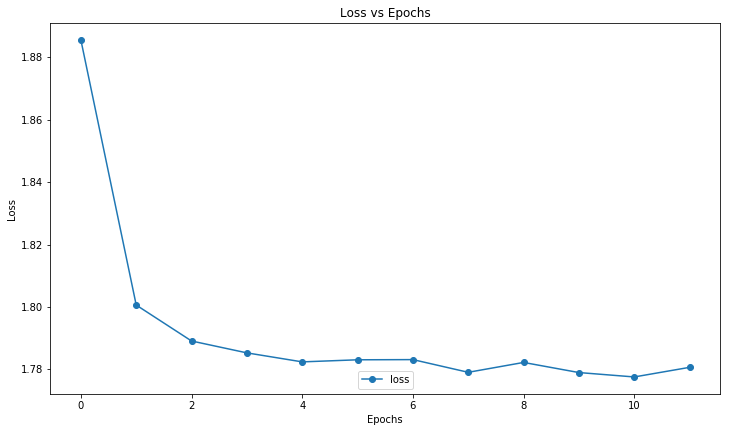

In [64]:
# Graph Loss
graph_loss(loss)

http://farm8.staticflickr.com/7193/7002905659_475abf08d2_z.jpg


/home/shared/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


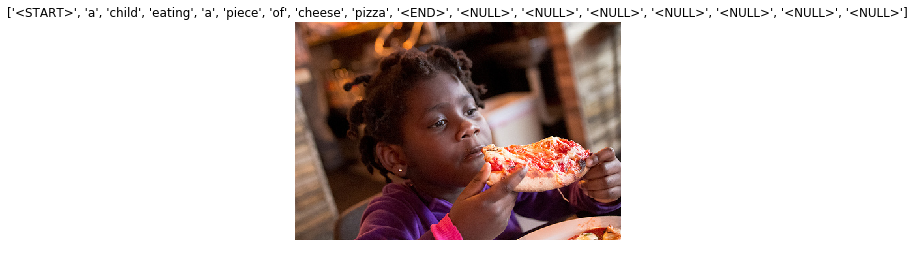

['a', 'woman', 'is', 'sitting', 'at', 'a', 'table', 'with', 'a', 'pizza', '<END>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>', '<NULL>']


In [106]:
#### Sample From Trained Model
gen_caption, target_captions = sample_model(decoder,785, valset)

In [72]:
# Compue BLEU Score over BATCH examples
BATCH = 10000
weights = (0.25, 0.25, 0.25, 0.25)
bleu4 = compute_bleu(decoder, BATCH, valset, (0.25, 0.25, 0.25, 0.25))
bleu3 = compute_bleu(decoder, BATCH, valset, (1./3., 1./3., 1./3.))
bleu2 = compute_bleu(decoder, BATCH, valset, (.5, .5))
bleu1 = compute_bleu(decoder, BATCH, valset, (1., 0, 0, 0))
print(bleu1,bleu2,bleu3,bleu4)
#print("Bleu Score 4 Over {} Examples in Trainset: {}".format(BATCH, compute_bleu(decoder, BATCH, weights, trainset)))
#print("Bleu Score 4 Over {} Examples in Valset: {}".format(BATCH, compute_bleu(decoder, BATCH, weights, valset)))

# 0.501284680569419 0.3211725838917276 0.2185196037561603 0.15962674506033595 epochs 30: training10,000
# epochs 12: Full Dataset 0.5081158660362612 0.3298369867854474 0.22572298833717613 0.1654623153051401

0.5081158660362612 0.3298369867854474 0.22572298833717613 0.1654623153051401


## Hyperparameter Search

In [73]:
def hyperparameter_search(lrs, decays, dropouts, epochs, embed_size, feature_size, use_glove, checkpoint=False):
    best_bleu = 0
    best_decoder = None
    for lr in lrs:
        for decay in decays:
            for dropout in dropouts:
                # Define Decoder Model
                decoder = DecoderRNN(embed_size, feature_size, len(vocab["word_to_idx"]), dropout, 1, 20, use_glove)
                decoder_name = 'decoder' + str(lr) + '_' + str(decay) + str(use_glove)
            
                # Define Optimizer
                optimizer = optim.Adam(decoder.parameters(), lr=lr, weight_decay=decay)
            
                # Train
                loss = train(decoder,
                         trainset_loader,
                         trainset.get_len(),
                         epochs, 
                         decoder_name, 
                         optimizer,  
                         batch_size=BATCH_SIZE,
                         checkpoint=checkpoint)
            
                # Sample Model for Image 50
                #_ , _  = sample_model(decoder, 50, valset)
            
                bleu = compute_bleu(decoder, BATCH, valset)
                print("Current Bleu Score: ", bleu)
            
                # Calculate Bleu Score
                if bleu > best_bleu: 
                    best_decoder = decoder 
                    best_bleu = bleu
                    if checkpoint: save_checkpoint('%s-best.pth' % decoder_name, decoder, optimizer)
                    
    return best_decoder

## Best Model

In [74]:
learning_rates = 10**(-np.random.rand(5)*4) # Randomly samples 5 learing rates on log scale between .1 and .0001
weight_decay = 10**(-np.random.rand(5)*5) # Randomly samples 5 weight decays on log scale between .1 and .00001
dropouts = np.random.rand(5)

best_decoder_0 = hyperparameter_search(learning_rates, weight_decay, dropouts, 4, 300, 512, True, checkpoint=True)
best_decoder_1 = hyperparameter_search(learning_rates, weight_decay, dropouts, 4, 300, 512, False, checkpoint=True)

Epoch Loss = 51.0012092590332 for Epoch 0
model saved to decoder0.2813433567119449_0.003529588687697173True_0.pth
Epoch Loss = 52.08768081665039 for Epoch 1
Epoch Loss = 51.70558166503906 for Epoch 2
Epoch Loss = 52.04935073852539 for Epoch 3
model saved to decoder0.2813433567119449_0.003529588687697173True_0_final.pth


TypeError: compute_bleu() missing 1 required positional argument: 'weights'